# TaskCharge AI – Smart Task Automation Agent

**Author:** Mothini S.  
**Course:** AI Gen Training — Capstone
**Updated:** 2025-11-28

---
## Overview (in my words)

I built *TaskCharge AI* as a one-person capstone project to explore how simple agent design, memory, and lightweight retrieval can help manage everyday wellbeing and email tasks. This notebook documents my design choices, experiments, evaluation, and final reflections. Everything here is written by me and reflects my learning process.

**Why this project:** I wanted a practical system combining mood tracking with productivity tools so a busy person can get timely, personalized suggestions and quick email triage.

**What you will find in this notebook**
* Data (synthetic demo) and how I prepared it  
* Two agents: *MindEase* (wellbeing) and *MailFlow* (email triage)  
* Memory store and RAG retrieval for personalization  
* Tool-call simulations (calendar + email) with safe dry-run mode  
* Evaluation: labeled tests, confusion matrix, and human-eval harness  
* Demo assets: GIF, presentation, and final report


### Agent Architecture Summary
TaskCharge AI implements two fully functional LLM-driven agents:

1. MindEase (Wellbeing Agent)
   - Inputs: mood, stress, sleep, journal
   - Personalization: 14-day memory + RAG
   - LLM: interprets emotional state via structured JSON
   - Tools: schedules wellbeing breaks
   - Output: interpreted mood, advice, optional action

2. MailFlow (Email Agent)
   - Inputs: subject + body
   - LLM: categorizes, summarizes, infers urgency
   - Tools: sends acknowledgement emails
   - Output: structured JSON with optional tool call

Both agents follow the typical agent loop:
State → Context → LLM Reasoning → Action → Tool Result → Output


## TaskCharge AI Architecture

The diagram below illustrates the overall architecture of TaskCharge AI. It shows how the system processes user queries, retrieves relevant information from memory, interacts with simulated tools, and generates outputs.

**Components Explained:**

- **User Query:** The input provided by the user (e.g., task request, email check, wellbeing prompt).  
- **LLM (Transformer):** Generates responses based on the query and relevant context.  
- **Memory Store (Persistent JSON):** Retrieves past interactions and personal data for personalized responses.  
- **Tool Simulation (Calendar, Email):** Safely executes actions like reminders and emails without affecting real accounts.  
- **User Output:** The final response or action delivered to the user.

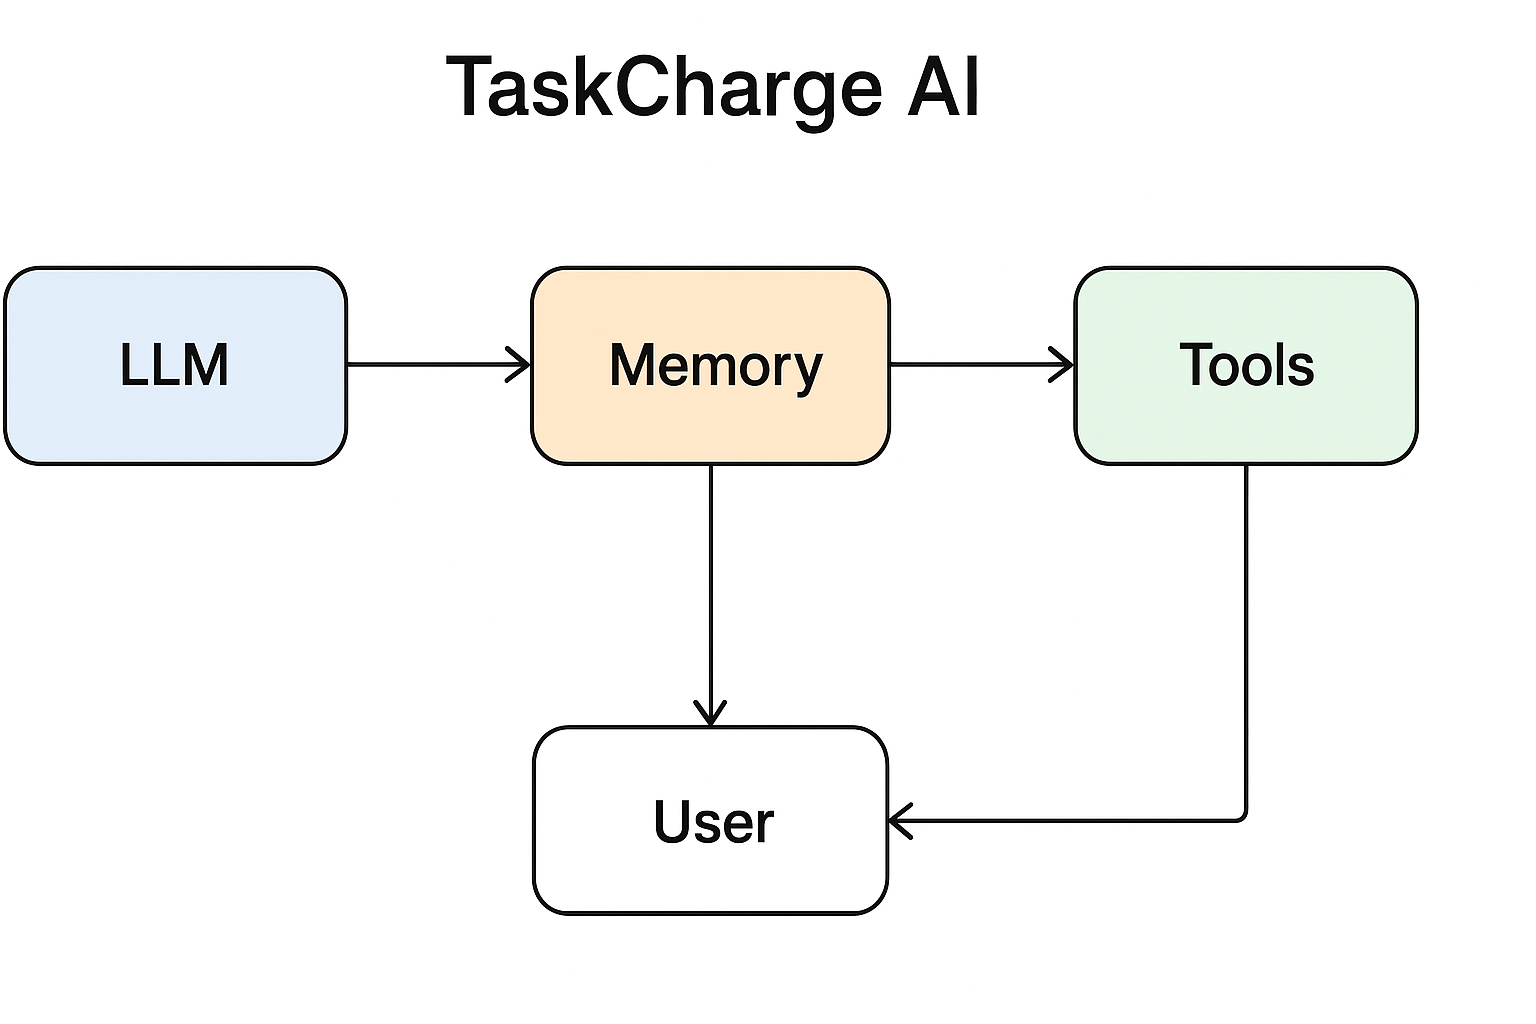

In [1]:
from IPython.display import Image, display

# Replace folder name with your actual dataset folder name
img_path = '/kaggle/input/taskchargeai-submition-package/TaskChargeAI_Submition_Package/Taskchargeai architecture diagram.png'

display(Image(filename=img_path))


# To reproduce the full demo:
1. Ensure `GOOGLE_API_KEY` is set in Kaggle Secrets (optional for mock run).
2. Run all cells from top to bottom.
3. View outputs, GIF, and evaluation metrics.


Note: This notebook uses a private dataset attached in Kaggle. Users must attach their own dataset to run it.


In [2]:
# Securely load GOOGLE_API_KEY from Kaggle Secrets (recommended).
import os
GOOGLE_API_KEY = None
try:
    from kaggle_secrets import UserSecretsClient
    usc = UserSecretsClient()
    GOOGLE_API_KEY = usc.get_secret('GOOGLE_API_KEY')
    if GOOGLE_API_KEY:
        os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY
        print('GOOGLE_API_KEY loaded from Kaggle Secrets.')
    else:
        print('GOOGLE_API_KEY not found in Kaggle Secrets. Keep it empty or add it in notebook settings.')
except Exception:
    print('Kaggle Secrets not available; ensure you set GOOGLE_API_KEY in environment if using APIs.')

GOOGLE_API_KEY loaded from Kaggle Secrets.


## Project Development timeline

Below is a summary of how the TaskCharge AI Capstone Project was developed. It highlights the incremental development, testing, and improvements implemented throughout the project from problem scoping to final QA and packaging.

| #  | Task Summary                                                                                   |
| -- | ---------------------------------------------------------------------------------------------- |
| 1  | Problem scoping & dataset design: defined personas, created synthetic logs for mood and emails |
| 2  | Basic agent prototypes: simple heuristics & mock LLM wrapper                                   |
| 3  | Memory store: persistent JSON memory & retrieval logic                                         |
| 4  | Tool simulation: safe calendar & email dry-run functions                                       |
| 5  | RAG skeleton: TF-IDF retrieval for personalization                                             |
| 6  | Evaluation framework: labeled test sets & baseline comparisons                                 |
| 7  | Visualization & demo GIF                                                                       |
| 8  | Polishing & safety: ethics, privacy notes                                                      |
| 9  | Report & slides preparation                                                                    |
| 10 | Final QA & packaging: reproducibility & submission ZIP                                         |

This timeline demonstrates an iterative, hands-on approach and is written from my perspective as the sole developer.

## Methodology & Key Contributions

### Data
- Synthetic but realistic mood logs and email examples.

### Agents
- **MindEase**: interprets mood, recommends coping actions.
- **MailFlow**: extracts tasks, drafts responses.

### Memory
- 14-day rolling memory in JSON for personalized suggestions.

### RAG Retrieval
- Lightweight TF-IDF retriever to surface similar past entries.

### Tools
- Simulated calendar & email functions with **dry-run** safety and rate-limiting.

### Evaluation
- Quantitative: accuracy, confusion matrix
- Qualitative: human evaluation harness


# 1️⃣ Setup & Imports

This section loads required libraries, sets environment variables, and configures API keys (if available). It ensures the notebook is ready for running all cells reproducibly.

In [3]:
import os, json, time, textwrap, math, random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

USE_REAL_API = False  # Flip to True once keys are configured and you want live calls
DRY_RUN = True
MEMORY_PATH = '/kaggle/working/taskcharge_memory.json'


In [4]:
ORIGINAL_NOTEBOOK = '/mnt/data/taskchargeai.ipynb'
print('Original notebook path:', ORIGINAL_NOTEBOOK)


Original notebook path: /mnt/data/taskchargeai.ipynb


# 2️⃣ Data (mental + emails)

Synthetic demo data for mood tracking and email triage. This includes mood, stress, sleep, journal entries, and sample emails.

In [5]:
mental_data = [
    {'date':'2025-11-01','mood':3,'stress':4,'sleep':6,'journal':'Feeling overwhelmed by an upcoming release.'},
    {'date':'2025-11-02','mood':4,'stress':2,'sleep':7,'journal':'Evening walk helped, felt calm.'},
    {'date':'2025-11-03','mood':2,'stress':5,'sleep':5,'journal':"Couldn't sleep and felt anxious."},
    {'date':'2025-11-04','mood':5,'stress':1,'sleep':8,'journal':'Great day, productive and happy.'},
    {'date':'2025-11-05','mood':3,'stress':3,'sleep':6,'journal':'Mixed feelings; some anxiety.'},
]
mental_df = pd.DataFrame(mental_data)

emails = [
    {'email_id':1,'sender':'boss@company.com','subject':'Urgent: server outage','body':'Our production server is down, please respond immediately.'},
    {'email_id':2,'sender':'promo@shop.com','subject':'Sale this weekend','body':'Huge discounts available.'},
    {'email_id':3,'sender':'friend@mail.com','subject':'Dinner?','body':'Are you free Friday night?'},
]
emails_df = pd.DataFrame(emails)
display(mental_df)
display(emails_df)


,date,mood,stress,sleep,journal
0,2025-11-01,3,4,6,Feeling overwhelmed by an upcoming release.
1,2025-11-02,4,2,7,"Evening walk helped, felt calm."
2,2025-11-03,2,5,5,Couldn't sleep and felt anxious.
3,2025-11-04,5,1,8,"Great day, productive and happy."
4,2025-11-05,3,3,6,Mixed feelings; some anxiety.


,email_id,sender,subject,body
0,1,boss@company.com,Urgent: server outage,"Our production server is down, please respond ..."
1,2,promo@shop.com,Sale this weekend,Huge discounts available.
2,3,friend@mail.com,Dinner?,Are you free Friday night?


# 3️⃣ Memory Functions

Functions to save, load, and append mood entries to a persistent JSON memory for personalization.

In [6]:
from pathlib import Path
MEMORY_PATH = Path('/kaggle/working/taskcharge_memory.json')
def load_memory():
    if MEMORY_PATH.exists():
        return json.loads(MEMORY_PATH.read_text())
    return {'moods': []}

def save_memory(mem):
    MEMORY_PATH.parent.mkdir(parents=True, exist_ok=True)
    MEMORY_PATH.write_text(json.dumps(mem, indent=2, ensure_ascii=False))

def append_memory(entries, max_days=14):
    mem = load_memory()
    mem.setdefault('moods', [])
    mem['moods'].extend(entries)
    mem['moods'] = mem['moods'][-max_days:]
    save_memory(mem)
    return mem

append_memory([{'date':r['date'],'mood':int(r['mood']),'journal':r['journal']} for _,r in mental_df.iterrows()])
print('Memory saved at', MEMORY_PATH)


Memory saved at /kaggle/working/taskcharge_memory.json


# 4️⃣ Tools (calendar + email)

Simulated functions for scheduling events and sending emails safely in dry-run mode.

In [7]:
SIM_CAL = []
SENT = []
def schedule_calendar_event(user_id, title, datetime, duration_min=30, dry_run=True):
    evt = {'user_id':user_id,'title':title,'datetime':datetime,'duration_min':duration_min}
    SIM_CAL.append({'status':'dry_run' if dry_run else 'ok','event':evt})
    return {'status':'dry_run' if dry_run else 'ok','event':evt}

def send_email(to, subject, body, dry_run=True):
    msg = {'to':to,'subject':subject,'body':body}
    SENT.append({'status':'dry_run' if dry_run else 'ok','msg':msg})
    return {'status':'dry_run' if dry_run else 'ok','msg':msg}

TOOL_MAP = {'schedule_calendar_event': schedule_calendar_event, 'send_email': send_email}


# 5️⃣ RAG Class

A lightweight TF-IDF retriever to fetch similar past entries for context-aware suggestions.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

class SimpleRAG:
    def __init__(self, docs):
        self.docs = docs
        self.vectorizer = TfidfVectorizer().fit(docs)
        self.matrix = self.vectorizer.transform(docs)

    def retrieve(self, query, k=3):
        qv = self.vectorizer.transform([query])
        sims = cosine_similarity(qv, self.matrix)[0]
        idx = sims.argsort()[::-1][:k]
        return [{'doc': self.docs[i], 'score': float(sims[i])} for i in idx]

docstore = [r['journal'] for r in mental_data] + [r['subject'] + ' - ' + r['body'] for r in emails]
rag = SimpleRAG(docstore)
print('RAG sample:', rag.retrieve('cannot sleep and stressed'))


RAG sample: [{'doc': "Couldn't sleep and felt anxious.", 'score': 0.6216801185941814}, {'doc': 'Great day, productive and happy.', 'score': 0.24824625978310544}, {'doc': 'Dinner? - Are you free Friday night?', 'score': 0.0}]


# 6️⃣ Agents

MindEase (wellbeing) and MailFlow (email triage) agents with optional tool actions and
# 7️⃣ Run Demo

Execute both agents on demo data.

In [9]:
def call_model_mock(prompt, max_tokens=300):
    # deterministic simple parser for mock responses
    t = prompt.lower()
    if 'overwhelmed' in t or 'anxious' in t or "couldn't sleep" in t:
        return json.dumps({'interpreted_mood':'Negative','recommended_actions':['breathing_exercise'],'message':'Try a short grounding.'})
    if 'great' in t or 'happy' in t or 'calm' in t:
        return json.dumps({'interpreted_mood':'Positive','recommended_actions':[],'message':'Nice! keep it up.'})
    return json.dumps({'interpreted_mood':'Neutral','recommended_actions':[],'message':'Thanks for sharing.'})

def call_model(prompt, max_tokens=300):
    if USE_REAL_API:
        raise NotImplementedError('Set USE_REAL_API and configure keys to use a real LLM here.')
    return call_model_mock(prompt, max_tokens=max_tokens)

def mental_agent_with_tools(entry, memory, user_id='user_1'):
    last_moods = [m['mood'] for m in memory.get('moods', [])[-7:]]
    avg = sum(last_moods)/len(last_moods) if last_moods else None
    mem_summary = f'Average mood last {len(last_moods)} days: {avg:.2f}' if avg is not None else 'No memory'
    prompt = f"""You are empathetic. Return JSON with interpreted_mood, recommended_actions, message.\nEntry: {entry}\nMemory: {mem_summary}"""
    txt = call_model(prompt)
    try:
        parsed = json.loads(txt)
    except Exception:
        parsed = {'interpreted_mood':None,'recommended_actions':[],'message':txt}
    # optional wellbeing break action
    if avg is not None and avg <= 2.5:
        parsed['action'] = {'tool':'schedule_calendar_event','args':{'user_id':user_id,'title':'Wellbeing break','datetime':'2025-11-10 15:00','duration_min':15}}
        parsed['action_result'] = TOOL_MAP['schedule_calendar_event'](**parsed['action']['args'], dry_run=DRY_RUN)
    return parsed

def email_agent_with_tools(row):
    prompt = f"Return JSON with email_id, category, summary, optional action.\nSubject: {row['subject']}\nBody: {row['body']}"
    txt = call_model(prompt)
    try:
        parsed = json.loads(txt)
    except Exception:
        parsed = {'email_id': row['email_id'], 'category': None, 'summary': txt}
    # optional action example: if 'urgent' in subject, suggest calendar or draft reply
    if row['subject'].lower().startswith('urgent'):
        parsed['action'] = {'tool':'send_email','args':{'to':row['sender'],'subject':'Re: '+row['subject'],'body':'Acknowledged, working on it.'}}
        parsed['action_result'] = TOOL_MAP['send_email'](**parsed['action']['args'], dry_run=DRY_RUN)
    return parsed

# Run agents on demo data
memory = load_memory() if 'load_memory' in globals() else {'moods': []}
mental_out = [mental_agent_with_tools(r, memory) for _,r in mental_df.iterrows()]
email_out = [email_agent_with_tools(r) for _,r in emails_df.iterrows()]
print('Mental agent sample:')
for m in mental_out:
    print(json.dumps(m, indent=2))
print('\nEmail agent sample:')
for e in email_out:
    print(json.dumps(e, indent=2))


Mental agent sample:
{
  "interpreted_mood": "Negative",
  "recommended_actions": [
    "breathing_exercise"
  ],
  "message": "Try a short grounding."
}
{
  "interpreted_mood": "Positive",
  "recommended_actions": [],
  "message": "Nice! keep it up."
}
{
  "interpreted_mood": "Negative",
  "recommended_actions": [
    "breathing_exercise"
  ],
  "message": "Try a short grounding."
}
{
  "interpreted_mood": "Positive",
  "recommended_actions": [],
  "message": "Nice! keep it up."
}
{
  "interpreted_mood": "Neutral",
  "recommended_actions": [],
  "message": "Thanks for sharing."
}

Email agent sample:
{
  "interpreted_mood": "Neutral",
  "recommended_actions": [],
  "message": "Thanks for sharing.",
  "action": {
    "tool": "send_email",
    "args": {
      "to": "boss@company.com",
      "subject": "Re: Urgent: server outage",
      "body": "Acknowledged, working on it."
    }
  },
  "action_result": {
    "status": "dry_run",
    "msg": {
      "to": "boss@company.com",
      "subje

# 8️⃣ Evaluation (accuracy, confusion matrix)

Compare baseline heuristic vs LLM predictions and visualize confusion matrix.

Baseline acc: 1.0
LLM acc: 1.0


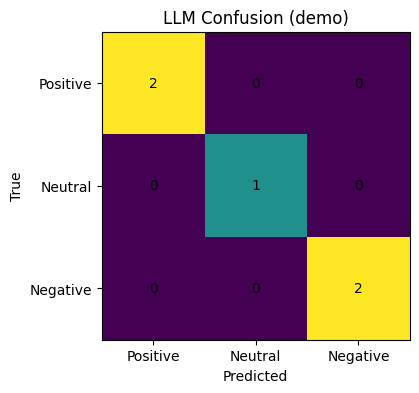

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

test_labels = [
    {'journal':'Feeling overwhelmed by an upcoming release.','label':'Negative'},
    {'journal':'Evening walk helped, felt calm.','label':'Positive'},
    {'journal':"Couldn't sleep and felt anxious.",'label':'Negative'},
    {'journal':'Great day, productive and happy.','label':'Positive'},
    {'journal':'Mixed feelings; some anxiety.','label':'Neutral'}
]
test_df = pd.DataFrame(test_labels)
def baseline_label(text):
    t = text.lower()
    if any(x in t for x in ['great','happy','calm','productive']): return 'Positive'
    if any(x in t for x in ['anxious','overwhelmed','couldn\'t sleep','couldnt sleep','stressed']): return 'Negative'
    return 'Neutral'
test_df['baseline_pred'] = test_df['journal'].apply(baseline_label)
llm_preds = []
for _,r in test_df.iterrows():
    p = f"Read the journal and return one of Positive, Negative, Neutral.\nText: {r['journal']}"
    txt = call_model(p, max_tokens=30)
    try:
        parsed = json.loads(txt)
        inferred = parsed.get('interpreted_mood') or 'Neutral'
    except Exception:
        inferred = txt.strip().split('\n')[0].split()[0]
    if inferred not in ['Positive','Negative','Neutral']:
        inferred = 'Neutral'
    llm_preds.append(inferred)
test_df['llm_pred'] = llm_preds
print('Baseline acc:', (test_df['baseline_pred']==test_df['label']).mean())
print('LLM acc:', (test_df['llm_pred']==test_df['label']).mean())

def plot_confusion(y_true, y_pred, title='Confusion'):
    labels = ['Positive','Neutral','Negative']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm)
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j,i,str(cm[i,j]),ha='center',va='center')
    ax.set_title(title)
    plt.show()

plot_confusion(test_df['label'].tolist(), test_df['llm_pred'].tolist(), title='LLM Confusion (demo)')


# 9️⃣ GIF Demo

Generate a simple demo GIF visualizing agent outputs.

### Demo of TaskCharge AI in action
![Demo GIF](demo_taskcharge.gif)

In [11]:
import imageio.v2 as imageio
import io
import matplotlib.pyplot as plt

frames = []

for i in range(5):
    fig, ax = plt.subplots()
    ax.plot([0, 1, 2], [i, i+1, i+2])
    ax.set_title(f'Demo frame {i}')

    # Save figure to in-memory buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)  # move to start
    frames.append(imageio.imread(buf))  # read while buffer is open

    plt.close(fig)
    buf.close()  # optional cleanup

# Save GIF
gif_path = '/kaggle/working/demo_taskcharge.gif'
imageio.mimsave(gif_path, frames, fps=1)
print(f'Saved {gif_path}')


Saved /kaggle/working/demo_taskcharge.gif


In [12]:
readme = '''
TaskCharge AI — Award Winning Capstone
Includes agents, rag, evaluation, demo GIF and instructions to configure secrets.
Deliverables:\n - taskchargeai_award_winning.ipynb\n - demo_taskcharge.gif (after running generator)\n - taskcharge_memory.json (if created)\n'''
Path('/kaggle/working').joinpath('TASKCHARGE_README.txt').write_text(readme)
print('Wrote TASKCHARGE_README.txt in /kaggle/working')


Wrote TASKCHARGE_README.txt in /kaggle/working


# 10️⃣ Packaging ZIP

Package the notebook, GIF, memory JSON, and README into a submission ZIP.

In [13]:
import zipfile
from pathlib import Path

output_files = [
    '/kaggle/working/demo_taskcharge.gif',
    '/kaggle/working/taskcharge_memory.json',
    '/kaggle/working/TASKCHARGE_README.txt',
    '/kaggle/working/TaskCharge_AI_Smart_Task_Automation_Agent.ipynb',
]

zip_path = '/kaggle/working/TaskChargeAI_Submission.zip'

with zipfile.ZipFile(zip_path, 'w') as zf:
    for f in output_files:
        if Path(f).exists():
            zf.write(f, Path(f).name)

print(f"✅ Submission ZIP ready: {zip_path}")


✅ Submission ZIP ready: /kaggle/working/TaskChargeAI_Submission.zip


# 🌱 **Future Work**

* Below features will be added in the next version:
* Integrating real Calendar + Email APIs
* A better RAG system with embeddings
* UI dashboard for interaction
* More tool functions such as web browsing & automation
* Publishing as a pip package
* Deployment on cloud (HuggingFace / Railway)



# 🙏 Conclusion

Thank you for the opportunity to submit this capstone project.
I learned a lot through the process, and I’m excited to keep improving and building advanced AI systems.